In [1]:
import boto3
import botocore
import functools
from IPython.core.display import display, HTML
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
from dishpylib.pyanalysis import calc_loglikelihoods_by_num_sets
from dishpylib.pyanalysis import count_hands_with_k_or_more_sets
from dishpylib.pyanalysis import count_hands_without_k_or_more_sets
from dishpylib.pyanalysis import estimate_interpolation_complexity
from dishpylib.pyanalysis import calc_loglikelihoods_over_set_sizes
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import NumpyEncoder
from dishpylib.pyhelpers import preprocess_competition_fitnesses
from dishpylib.pyhelpers import print_runtime


In [3]:
print_runtime()


context: ci
hostname: runnervmyfcvg
interpreter: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
notebook name: 2025-09-09-biotic_complexity
notebook path: /home/runner/work/oee4/oee4/binder/2025-09-09-biotic_complexity.ipynb
revision: bdac574
timestamp: 2025-09-12T16:04:06Z00:00

IPython==7.16.1
packaging==25.0


<ipython-input-3-4d790cf6450f>:1: DeprecatedWarning: print_runtime is deprecated. use nbmetalog package instead
  print_runtime()


In [4]:
teeplot_subdir = "2025-09-05-interpolation_complexity"


In [5]:
import boto3
import botocore
import functools
import pandas as pd

from dishpylib.pyhelpers import fit_control_t_distns

@functools.lru_cache
def get_control_t_distns( bucket, endeavor, stint ):

    s3_handle = boto3.resource(
        's3',
        region_name="us-east-2",
        config=botocore.config.Config(
            signature_version=botocore.UNSIGNED,
        ),
    )
    bucket_handle = s3_handle.Bucket(bucket)

    control_competitions, = bucket_handle.objects.filter(
        Prefix=f'endeavor={endeavor}/control-competitions-focalbb/stage=4+what=collated/stint={stint}/',
    )

    control_df = pd.read_csv(
        f's3://{bucket}/{control_competitions.key}',
    )

    return fit_control_t_distns(control_df[
        control_df["Root ID"] == 1
    ].copy())


In [6]:
import functools
from iterpop import iterpop as ip
from scipy import stats


def preprocess_competition_fitnesses(competitions_df, control_fits_df):
    # preprocess data
    @functools.lru_cache
    def h0_fit(series):
        return ip.popsingleton(
            control_fits_df[control_fits_df["Series"] == series].to_dict(
                orient="records",
            )
        )

    competitions_df["p"] = competitions_df.apply(
        lambda row: stats.t.cdf(
            row["Fitness Differential"],
            h0_fit(row["genome series"])["Fit Degrees of Freedom"],
            loc=h0_fit(row["genome series"])["Fit Loc"],
            scale=h0_fit(row["genome series"])["Fit Scale"],
        ),
        axis=1,
    )
    competitions_df["Is Less Fit"] = competitions_df["p"] < 1.0 / 40
    competitions_df["Is More Fit"] = competitions_df["p"] > (1.0 -  1.0 / 40)
    competitions_df["Is Neutral"] = ~(
        competitions_df["Is Less Fit"] | competitions_df["Is More Fit"]
    )
    competitions_df["Relative Fitness"] = competitions_df.apply(
        lambda row: (
            "Significantly Advantageous"
            if row["Is More Fit"]
            else (
                "Significantly Deleterious" if row["Is Less Fit"] else "Neutral"
            )
        ),
        axis=1,
    )

    return competitions_df


# get data


In [7]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

dfs = []
for stint in range(1, 101):
# for stint in (19,):
    print(stint)
    series_profiles, = bucket_handle.objects.filter(
        Prefix=f'endeavor=16/variant-competitions-focalbb/stage=4+what=collated/stint={stint}/',
    )
    control_fits_df = get_control_t_distns('prq49', 16, stint)
    df = pd.read_csv(
        f's3://prq49/{series_profiles.key}',
        compression='xz',
    )
    df["Stint"] = stint
    dfdigest = '{:x}'.format( hash_pandas_object( df ).sum() )
    print(dfdigest)
    df = preprocess_competition_fitnesses(df, control_fits_df)
    dfs.append(df)


1
68213c7d0f6f4a89
2
-2ae10ebb03b92bbe
3
-282fcc7266c187d1
4
435ea52e768948cb
5
3e782baaf377b2c0
6
238a06d0c729df9
7
1aaaa42c4e2ceb16
8
18813168c9fe21d0
9
-294f360c9876fa76
10
-5f78d9f634b2955e
11
-425d89b2f9ce3864
12
-757ed41b6acd5d8a
13
44ac720ff7009686
14
-60314ddb710a32fa
15
-37b35280599fed93
16
-52faa167b0a3d95f
17
584720f04befc070
18
1af78cced8f903d6
19
-4ca48b1b71e563ff
20
772f0ea02fd50a60
21
-7eced6b6a7db195
22
-40bd3c9dc06b14e3
23
-6e97a77709cdd5b5
24
6aa325e9cef7099f
25
146d8d92e51c9ada
26
6365fab53c02acf
27
d6ed6049c81afe
28
-799898be8f6d2462
29
-401fc18e01936e8
30
7d4dc39d97055087
31
24c098c4d22afb3b
32
51b7d3f72b902cd7
33
-57279068d66006dc
34
5441d4bd69e148ef
35
25d81c8ff7c3f526
36
f80e04918ff2932
37
-1ad092793935929
38
da5f370d85e98fe
39
402a905b79c79fdb
40
-7826749fd9486eb2
41
7aa867da87fdb918
42
-18f05027df880ee0
43
16ab53047455aac4
44
-21f485c35940fbc1
45
-70e687bd133de9a2
46
691158831657524c
47
430b06e81392babd
48
-ca4b4e8418190ba
49
61875e20eac8135c
50
-66a89429848ee

In [8]:
df = pd.concat(dfs)


In [9]:
dfx = df[
    df["Root ID"] == 1
].groupby("Stint").agg(
    {
        "Is More Fit": "sum",
        "Is Less Fit": "sum",
        "Is Neutral": "sum",
    },
)
dfx


,Is More Fit,Is Less Fit,Is Neutral
Stint,,,
1,2,8,34
2,2,24,42
3,0,25,52
4,0,13,72
5,4,13,56
...,...,...,...
96,2,126,1274
97,0,39,115
98,0,37,129


Text(0, 0.5, 'Num Sites')

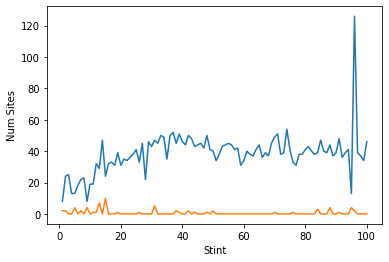

In [10]:
sns.lineplot(
    data=dfx,
    markers=True,
    x="Stint",
    y="Is Less Fit",
)
sns.lineplot(
    data=dfx,
    markers=True,
    x="Stint",
    y="Is More Fit",
)
plt.gca().set_ylabel("Num Sites")
